In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from numba import jit

In [2]:
output_path = '/home/bruce1996/data/pr/0627/'

In [3]:
deseq_output = '/home/bruce1996/ssd/mci_deseq_res.txt'
humann_output = '/home/bruce1996/ssd/mci_rel_pathabundance.tsv'
metaphlan_output = "/home/bruce1996/nvme2/mci_for_adlasso/data/MCI_species_relative_abundance.txt"
humann_df = pd.read_csv(humann_output,sep = '\t',index_col=0)
humann_df.index.name = None
deseq_df = pd.read_csv(deseq_output,sep = '\t',index_col = 0)
meta_df = pd.read_csv(metaphlan_output,sep = '\t',index_col=0)

In [4]:
corr_m = meta_df.T.corr('spearman')
tmp = corr_m.copy()
ut = np.triu(tmp,k=1)
ut = np.where(ut==0, np.nan, ut)
ut_df = pd.DataFrame(ut,index = corr_m.index,columns = corr_m.columns)
tmp = ut_df
tmp['taxa'] = ut_df.index
tmp = tmp.melt(id_vars='taxa')
tmp.columns = ['t1','t2','corr']

In [5]:
##remove un of humann result
idx = [bool(re.search('UN',x)) == False for x in humann_df.index]
humann_df = humann_df.loc[idx,:]
##remove special charcter from humann output index
removeSpecialChars = lambda x : x.translate ({ord(c): "" for c in "[]"})
humann_df.index = list(map(removeSpecialChars,list(humann_df.index) ))

In [6]:
select_feature_list  = "/home/bruce1996/nvme2/mci_for_adlasso/MCI/selected_feature.txt"

select_feature = pd.read_csv(select_feature_list,sep='\t',header=None)
select_feature.columns = ['Species']
candidate_df = deseq_df.loc[select_feature['Species'].values,:]


In [7]:
import seaborn as sns
from math import log10

def valcano_plot_for_deseq2(deseq_df,figname,title,fc_threshold = 1,pv_threshold = 0.05,figsize= (10,6)) :
    '''
    function of deseq2 result output to valcano plot
    deseq_df : dataframe, deseq result output
    fc_threshold : int/float, significant threshold of log2foldchange 
    pv_threshold : float, significant threhold of p-value
    '''
    plot_df = deseq_df.copy()
    plot_df['Significant'] = np.where((abs(plot_df['log2FoldChange']) > fc_threshold) & (plot_df['pvalue'] < pv_threshold), 'Significant','Non-significant')
    plt.figure(figsize=figsize)
    plot_df['log10 pvalue'] = [abs(log10(x)) for x in plot_df['pvalue'].values]
    sns.scatterplot(data = plot_df,x = 'log2FoldChange',y = 'log10 pvalue',hue='Significant',palette='Set2')
    max_fc = max(abs(plot_df['log2FoldChange']))
    plt.xlim([-1 * max_fc,max_fc])
    plt.title(title,fontsize = 12)
    plt.savefig(figname,dpi = 300)


In [8]:
@jit(nopython=True)
def enrich_score(taxa_array) : 
    '''
    pathway : name of pathway, ex : DTDPRHAMSYN-PWY: dTDP-&beta;-L-rhamnose biosynthesis
    taxonomy_list : taxonomy list with "order"
    '''
    #calculate enrichment score unit, enrichment score upper bond = 1, lower bond = -1
    es = 0
    max_es = 0
    es_pos = 1/sum(taxa_array)
    es_n = 1/(len(taxa_array) - sum(taxa_array))
    #calculate enrichment score by "ordered" taxonomy list
    for t in taxa_array :
        if t  == 1 :
            es += es_pos
        elif t == 0 :
            es -= es_n
        else :
            print('Value in taxa array must be 0 or 1')
            break
        if es > max_es :
            max_es = es
    return max_es

@jit(nopython=True)
def permutation(taxa_array,n_times = 1000) :
    
    origin_es = enrich_score(taxa_array)
    permutation_es = np.zeros(n_times)
    for i in range(n_times) :
        np.random.shuffle(taxa_array)
        permutation_es[i] = enrich_score(taxa_array)
    es_above_origin = sum(permutation_es > origin_es)
    if es_above_origin == 0 :
        pesudo_f = 1/ (n_times * 10)
    else :
        pesudo_f = es_above_origin / n_times
    return pesudo_f,origin_es

In [9]:
import random
import time

class taxonomy_enrich_analysis :

    def __init__(self,deseq_output,metaphlan_output,humann_index) :
        self.deseq = deseq_output
        self.metaphlan_output = metaphlan_output
        self.taxonomy = list(self.deseq.index)
        self.humann_index = humann_index
        p_idx = [bool(re.search("^(?!.*\|)",x)) for x in self.humann_index]
        self.pathway_list = self.humann_index[p_idx]
        self.pseudo_p_value = np.zeros(len(self.pathway_list))
        self.es_score = np.zeros(len(self.pathway_list))

    def sort_taxonomy(self,method='fold-change') :
        if method == 'fold-change' :
            self.deseq = self.deseq.sort_values(by='log2FoldChange',ascending=False)
            self.taxonomy = list(self.deseq.index)
        elif method == 'p-value' :
            self.deseq = self.deseq.sort_values(by='padj',ascending=False)
            self.taxonomy = list(self.deseq.index)
        else :
            self.taxonomy = self.taxonomy

    def sort_taxonomy_edge(self,method = 'spearman') :
        corr_matrix = self.metaphlan_output.T.corr(method)
        ut = np.triu(corr_matrix.to_numpy(),k=1)
        ut = np.where(ut==0, np.nan, ut)
        ut_df = pd.DataFrame(ut,index = corr_matrix.index,columns = corr_matrix.columns)
        ut_df['taxa'] = corr_matrix.index
        ut_df = ut_df.melt(id_vars='taxa')
        ut_df.columns = ['T1','T2','corr']
        idx = ut_df['corr'].isnull() == False
        ut_df = ut_df.loc[idx,:].sort_values(by='corr')
        self.taxonomy = list(zip(ut_df['T1'],ut_df['T2']))
    
    def format_taxa_array(self,pathway,taxa_list,mode='Node') :
        taxa_idx = [bool(re.search(pathway,x)) for x in self.humann_index]
        taxa_in_path = self.humann_index[taxa_idx]

        taxa_in_pathway = lambda x : x.split('|')[-1].split('.')[-1]
        taxa_in_path = list(map(taxa_in_pathway,taxa_in_path[1:]))
        taxa_array = np.zeros(len(taxa_list))
        for idx,t in enumerate(taxa_list) :
            if mode == 'Node' :
                if t in taxa_in_path :
                    taxa_array[idx] = 1
            else :
                if t[0] in taxa_in_path and t[1] in taxa_in_path :
                    taxa_array[idx] = 1

        return taxa_array

    def TSEA(self,mode='Node') :
        if mode == 'Node' :
            self.sort_taxonomy()
        elif mode == 'Edge' :
            self.sort_taxonomy_edge()
        else :
            print('Only have Node/Edge mode for taxonomy set enrichment analysis')
            return
        print('taxonomy list length : %d' % len(self.taxonomy))
        for idx,p in enumerate(self.pathway_list) :
            start_time = time.time()
            print('Calculate enrichment score of {idx} / {total}  pathway : {pathway}'.format(idx =idx+1,total = len(self.pathway_list),pathway =p))
     
            if mode == 'Node' :
                taxa_array = self.format_taxa_array(p,self.taxonomy)
            else :
                taxa_array = self.format_taxa_array(p,self.taxonomy,mode='Edge')
            if sum(taxa_array) == 0 :
                pass
            else :
                self.pseudo_p_value[idx],self.es_score[idx] = permutation(taxa_array)
            
            end_time = time.time()
            time_delta = round(end_time - start_time,2)
            #print('Pathway : {p} pesudo-F : {f}, enrich score : {es}'.format(p=p,f=self.pseudo_p_value[idx],es=self.es_score[idx] ))
            print('TSEA of pathway : %s cost %0.2f s' % (p,time_delta))

        tsea_result = pd.DataFrame({'Pathway' : self.pathway_list,'Enrich_score' : self.es_score,'p-value' : self.pseudo_p_value})
        return tsea_result


In [10]:
tt = taxonomy_enrich_analysis(deseq_df,meta_df,humann_df.index)
node_tsea = tt.TSEA()

taxonomy list length : 410
Calculate enrichment score of 1 / 508  pathway : 12DICHLORETHDEG-PWY: 1,2-dichloroethane degradation
TSEA of pathway : 12DICHLORETHDEG-PWY: 1,2-dichloroethane degradation cost 0.02 s
Calculate enrichment score of 2 / 508  pathway : 1CMET2-PWY: folate transformations III (E. coli)
TSEA of pathway : 1CMET2-PWY: folate transformations III (E. coli) cost 0.02 s
Calculate enrichment score of 3 / 508  pathway : 3-HYDROXYPHENYLACETATE-DEGRADATION-PWY: 4-hydroxyphenylacetate degradation
TSEA of pathway : 3-HYDROXYPHENYLACETATE-DEGRADATION-PWY: 4-hydroxyphenylacetate degradation cost 0.89 s
Calculate enrichment score of 4 / 508  pathway : AEROBACTINSYN-PWY: aerobactin biosynthesis
TSEA of pathway : AEROBACTINSYN-PWY: aerobactin biosynthesis cost 0.04 s
Calculate enrichment score of 5 / 508  pathway : ALL-CHORISMATE-PWY: superpathway of chorismate metabolism
TSEA of pathway : ALL-CHORISMATE-PWY: superpathway of chorismate metabolism cost 0.02 s
Calculate enrichment sco

In [107]:
edge_tsea = edge_tsea.sort_values(by='p-value')

In [14]:
edge_tsea = pd.read_csv('TSEA/tsea_edge.csv',sep='\t')

In [16]:
edge_tsea = edge_tsea.sort_values(by='Pathway')
node_tsea = node_tsea.sort_values(by='Pathway')

In [19]:
df = pd.DataFrame({'Node' : node_tsea['p-value'],'Edge' : edge_tsea['p-value']})

In [32]:
idx = edge_tsea.sum(axis=1) > 0
edge_tsea = edge_tsea.loc[idx,:]
edge_tsea.index = edge_tsea['Pathway']

idx = node_tsea.sum(axis=1) > 0
node_tsea = node_tsea.loc[idx,:]
node_tsea.index = node_tsea['Pathway']

/tmp/ipykernel_3211707/2616584631.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  idx = edge_tsea.sum(axis=1) > 0
/tmp/ipykernel_3211707/2616584631.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  idx = node_tsea.sum(axis=1) > 0


In [34]:
path = list(set(edge_tsea.index).intersection(node_tsea.index))
edge_tsea = edge_tsea.loc[path,:]
node_tsea = node_tsea.loc[path,:]

In [37]:
df = pd.DataFrame({'Node' : node_tsea['p-value'],'Edge' : edge_tsea['p-value']})

In [54]:
df.loc[(df['Node'] < 0.1),:]

,Node,Edge
Pathway,,
PWY-7790: UMP biosynthesis II,0.047,0.0001
PWY-6277: superpathway of 5-aminoimidazole ribonucleotide biosynthesis,0.056,0.0001
UDPNAGSYN-PWY: UDP-N-acetyl-D-glucosamine biosynthesis I,0.002,0.0001
PWY-6163: chorismate biosynthesis from 3-dehydroquinate,0.071,0.0001
PWY-6151: S-adenosyl-L-methionine salvage I,0.058,0.0001
THRESYN-PWY: superpathway of L-threonine biosynthesis,0.023,0.0010
PWY-6122: 5-aminoimidazole ribonucleotide biosynthesis II,0.055,0.0001
"PWY-724: superpathway of L-lysine, L-threonine and L-methionine biosynthesis II",0.052,0.0001
PWY-7791: UMP biosynthesis III,0.075,0.0001


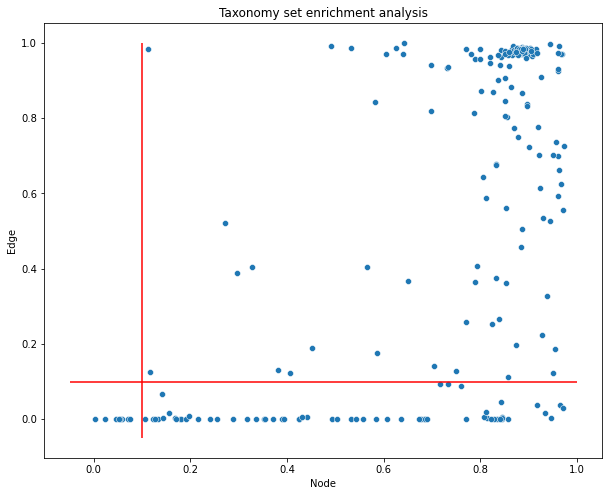

In [53]:
plt.figure(figsize=(10,8))
sns.scatterplot(data = df ,x='Node',y='Edge')
plt.vlines(0.1,-0.05,1,colors='r')
plt.hlines(0.1,-0.05,1,colors='r')
plt.title('Taxonomy set enrichment analysis',fontsize = 12)
plt.savefig(output_path + 'tsea_scatterplot.png',dpi = 300)